Validation of the mobility estimator
------------------

The variables expressed in the linear regression model to estimate mobility are used to build a machine learning model that can be used as a mobility prediction model. In this notebook, we prepare the dataset to build the model and also validate the model using validation dataset. Auto AI is used to build the model. The mobility estimator is currently built for Berlin and London


Data used
----------
In order to run the cells the data has to be downloaded manually from these sources. Special thanks to the following sources for providing an open source license to access the data.

* Apple mobility data: https://covid19.apple.com/mobility
* Oxford stringency: https://github.com/OxCGRT/covid-policy-tracker
* Weather forecast from Yr, delivered by the Norwegian Meteorological Institute and NRK: https://api.met.no/weatherapi/locationforecast/2.0/
* Historical weather data from https://mesonet.agron.iastate.edu/ASOS/

Steps:
---- 

1. Create the features: lockdown+air_temperature+is_weekend+lockdown*is_weekend
2. Split the data into train (Jan-Sep) and validation (Sep-Oct) set
3. Build the model using Auto AI and XGBoost Regressor and compare the results.
4. Validate the model using the validation set

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from ipywidgets import Dropdown,IntSlider
from IPython.display import display
import os
import requests
import json

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

try:
    import xgboost
except:
    !pip install xgboost

%matplotlib inline
from functools import reduce
try:
    from dowhy import CausalModel
except:
    #!pip install sympy
    !pip install -I dowhy
    from dowhy import CausalModel

### Preparation of dataset for Berlin and validation

In [ ]:
from project_lib import Project
project = Project.access()
Oxford_Stringency_Index_credentials = project.get_connected_data(name="Oxford Stringency Index")

import dsx_core_utils, os, io
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy

sqla_url= "db2+ibm_db://" + Oxford_Stringency_Index_credentials['username']+ ':' + Oxford_Stringency_Index_credentials['password'] + "@"+ Oxford_Stringency_Index_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
engine = create_engine(sqla_url, pool_size=10, max_overflow=20)
conn = engine.connect()

# Stringency
ox_df = pd.read_sql_table("oxford_stringency_index", conn)
ox_df["date"] = pd.to_datetime(ox_df["date"],format="%Y%m%d")

be_ox_df = ox_df[ox_df.countrycode=="DEU"]
be_ox_df.index= be_ox_df['date']
be_ox_df = be_ox_df[['stringencyindex']]

# Transit mobility
Apple_transit_mobility_credentials = project.get_connected_data(name="Apple Transit Mobility")

apple_sqla_url= "db2+ibm_db://" + Apple_transit_mobility_credentials['username']+ ':' + Apple_transit_mobility_credentials['password'] + "@"+ Apple_transit_mobility_credentials['host'] + ":50001/BLUDB;Security=ssl;"

apple_engine = create_engine(apple_sqla_url, pool_size=10, max_overflow=20)
apple_conn = apple_engine.connect()

app_mob_df = pd.read_sql_table(Apple_transit_mobility_credentials['datapath'].split("/")[-1].lower(), apple_conn,index_col=['Timestamp'])
be_app_trans_df = app_mob_df[app_mob_df.region=='Berlin']
be_app_trans_df.drop(columns=['region'],inplace=True)

# Berlin air temperature
r=requests.get('https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=EDDB&data=tmpc&year1=2020&month1=1&day1=1&year2=2020&month2=12&day2=7&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2')
df_airtemp_be = pd.read_csv(io.BytesIO(r.content))
df_airtemp_be.index = pd.to_datetime(df_airtemp_be['valid'].values)
df_airtemp_be.drop(['station','valid'],axis=1,inplace=True)
df_airtemp_be = df_airtemp_be.resample('1D').median()
df_airtemp_be.rename({'tmpc':'air_temperature'},axis=1,inplace=True)


dfs = [be_ox_df,be_app_trans_df,df_airtemp_be]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs)

df_final.rename({'stringencyindex':'lockdown'},axis=1,inplace=True)


df_final['is_weekend'] = np.where((df_final.index.weekday == 5)|(df_final.index.weekday == 6),1,0)

In [4]:
df_final['lockdown_is_weekend'] = df_final['lockdown']*df_final['is_weekend']

In [5]:
df_final.head()

,lockdown,mobility,air_temperature,is_weekend,lockdown_is_weekend
2020-01-13,0.0,100.00,5.0,0,0.0
2020-01-14,0.0,104.84,9.0,0,0.0
2020-01-15,0.0,104.32,10.0,0,0.0
2020-01-16,0.0,109.63,6.0,0,0.0
2020-01-17,0.0,119.85,3.0,0,0.0


In [6]:
train_df = df_final[df_final.index<=datetime.datetime(2020,9,15)].dropna()
validation_df = df_final[df_final.index>datetime.datetime(2020,9,15)].dropna()

In [7]:
train_df.to_csv('/project_data/data_asset/mercury/berlin_mobility_estimator_train_encoding.csv',index=False)

Build XGBoost Regressor model for comparison

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_df[['lockdown','air_temperature','lockdown_is_weekend','is_weekend']].to_numpy(), train_df['mobility'].to_numpy(), test_size=0.3, random_state=42)

In [10]:
skmodel = Pipeline([('scaler',StandardScaler()),
                    ('clf',xgboost.XGBRegressor(silent=True, random_state=42))])

param_grid = {
    "scaler__with_mean":[True,False],
    "scaler__with_std":[True,False],
    "clf__n_estimators": [10, 50, 100, 500],
    "clf__learning_rate": [0.1, 0.5, 1],
}

searchCV = GridSearchCV(skmodel, cv=5, param_grid=param_grid)
searchCV.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        XGBRegressor(random_state=42,
                                                     silent=True))]),
             param_grid={'clf__learning_rate': [0.1, 0.5, 1],
                         'clf__n_estimators': [10, 50, 100, 500],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]})

In [11]:
y_pred = searchCV.best_estimator_.predict(X_test)

**Model metrics on test data set**

In [12]:
print("Mean absolute error: {}, Mean squared error: {}, R² score: {}".format(mean_absolute_error(y_test,y_pred),mean_squared_error(y_test,y_pred),r2_score(y_test,y_pred)))

Mean absolute error: 9.067447416975691, Mean squared error: 155.62318304159024, R² score: 0.8517358184550785


**Model metrics on validation data set**

In [14]:
y_validation_true = validation_df['mobility'].values
y_validation_pred = searchCV.best_estimator_.predict(validation_df[['lockdown','air_temperature','lockdown_is_weekend','is_weekend']].values)

In [15]:
print("Mean absolute error: {}".format(mean_absolute_error(y_validation_true,y_validation_pred)))

Mean absolute error: 30.21267822079543


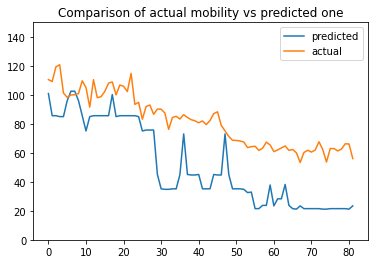

In [16]:
plt.plot(y_validation_pred)
plt.plot(y_validation_true)
plt.legend(['predicted',"actual"])
plt.ylim(0,150)
plt.title("Comparison of actual mobility vs predicted one")
plt.show()

**Use Auto AI to build the model and deploy it**

To use Auto AI, the user must use have an account on IBM cloud.

Berlin_mobility_estimator

In [17]:
array_of_input_fields = ['lockdown','air_temperature','lockdown_is_weekend','is_weekend']
values = validation_df[['lockdown','air_temperature','lockdown_is_weekend','is_weekend']].values.tolist()

In [31]:
mltoken = os.environ['USER_ACCESS_TOKEN']

In [32]:
# NOTE: you must construct mltoken based on provided documentation	
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": array_of_input_fields, "values": values}]}

response_scoring = requests.post('https://zen-cpd-zen.emergent-alliance-cp4d-8adf5438ca4a45887fba35bbc75e0113-0000.eu-gb.containers.appdomain.cloud/v4/deployments/a55ad77e-7c82-458a-9895-ceb636a497bb/predictions',
                                 json=payload_scoring, headers=header,verify=False)

In [35]:
auto_ai_predictions = [x[0] for x in response_scoring.json()['predictions'][0]['values']]
auto_ai_pred = pd.DataFrame(auto_ai_predictions,columns=['predictions'])

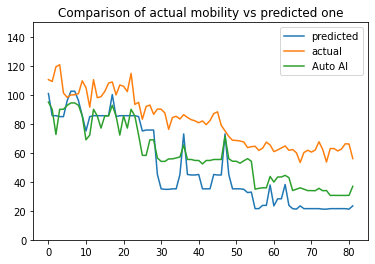

In [37]:
plt.plot(y_validation_pred)
plt.plot(y_validation_true)
plt.plot(auto_ai_pred.values)
plt.legend(['predicted',"actual","Auto AI"])
plt.ylim(0,150)
plt.title("Comparison of actual mobility vs predicted one")
plt.show()

In [38]:
mean_absolute_error(y_validation_true,auto_ai_pred.values)

### Preparation of dataset for London and validation

In [18]:
app_df = pd.read_csv("/project_data/data_asset/sun/apple_mobility/applemobilitytrends-2020-10-14.csv")


from project_lib import Project
project = Project.access()
Oxford_Stringency_Index_credentials = project.get_connected_data(name="Oxford Stringency Index")

import dsx_core_utils, os, io
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy

sqla_url= "db2+ibm_db://" + Oxford_Stringency_Index_credentials['username']+ ':' + Oxford_Stringency_Index_credentials['password'] + "@"+ Oxford_Stringency_Index_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
engine = create_engine(sqla_url, pool_size=10, max_overflow=20)
conn = engine.connect()

ox_df = pd.read_sql_table("oxford_stringency_index", conn)
ox_df["date"] = pd.to_datetime(ox_df["date"],format="%Y%m%d")

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/sqlalchemy/engine/reflection.py:884: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'oxford_stringency_index'
  "columns for table '%s'" % (flavor, c, table_name)


In [19]:
def region_specific_data(mobility_region,weather_station,stringency_country_code):

    cs_app_trans_df = app_df[(app_df.region==mobility_region)&
                           (app_df.transportation_type=="transit")].drop(['geo_type','region','transportation_type',
                                                                          'alternative_name','sub-region','country'],axis=1).transpose()
    cs_app_trans_df.columns= ['mobility']

    # Stringency Germany

    if stringency_country_code == "GBR":
        # Consider only England
        cs_ox_df = ox_df[ox_df.regionname=="England"]
        cs_ox_df.index= cs_ox_df['date']
        cs_ox_df = cs_ox_df[['stringencyindex']]
        
    elif stringency_country_code == "USA":
        # Consider only New York
        cs_ox_df = ox_df[ox_df.regionname=="New York"]
        cs_ox_df.index= cs_ox_df['date']
        cs_ox_df = cs_ox_df[['stringencyindex']]
    else:
        cs_ox_df = ox_df[ox_df.countrycode==stringency_country_code]
        cs_ox_df.index= cs_ox_df['date']
        cs_ox_df = cs_ox_df[['stringencyindex']]

    # Max temperature

    historical_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station={}&data=tmpc&year1=2020&month1=1&day1=1&year2=2020&month2=10&day2=28&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2".format(weather_station)
    hist_weather_df = pd.read_csv(historical_url)

    # Replace missing and trace as na
    hist_weather_df.replace("M",np.nan,inplace=True)
    hist_weather_df.replace("M",np.nan,inplace=True)

    #Convert to float
    hist_weather_df['tmpc'] = hist_weather_df['tmpc'].astype(np.float64)
    hist_weather_df['valid'] = pd.to_datetime(hist_weather_df['valid'])

    hist_weather_df.rename({'valid':'time','tmpc':'air_temperature'},axis=1, inplace=True)

    hist_weather_df.index = hist_weather_df['time']
    hist_weather_df = hist_weather_df.resample("1D").median()

    dfs = [cs_ox_df,cs_app_trans_df,hist_weather_df]
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs)

    df_final.rename({'stringencyindex':'lockdown'},axis=1,inplace=True)
    df_final['is_weekend'] = np.where((df_final.index.weekday == 5)|(df_final.index.weekday == 6),1,0)
    
    df_final['lockdown_is_weekend'] = df_final['lockdown']*df_final['is_weekend']
    df_final_ = df_final[['lockdown','air_temperature','lockdown_is_weekend','mobility','is_weekend']]
    
    return df_final_

In [20]:
london_df = region_specific_data('London','EGLL', 'GBR')

In [21]:
ln_train_df = london_df[london_df.index<=datetime.datetime(2020,9,15)].dropna()
ln_validation_df = london_df[london_df.index>datetime.datetime(2020,9,15)].dropna()

In [22]:
ln_train_df.to_csv('/project_data/data_asset/mercury/london_mobility_estimator_train_encoding.csv',index=False)

Build XGBoost model for comparison

In [23]:
X_train_ln, X_test_ln, y_train_ln, y_test_ln = train_test_split(ln_train_df[['lockdown','air_temperature','lockdown_is_weekend','is_weekend']].to_numpy(), ln_train_df['mobility'].to_numpy(), test_size=0.3, random_state=42)

In [24]:
skmodel = Pipeline([('scaler',StandardScaler()),
                    ('clf',xgboost.XGBRegressor(silent=True, random_state=42))])

param_grid = {
    "scaler__with_mean":[True,False],
    "scaler__with_std":[True,False],
    "clf__n_estimators": [10, 50, 100, 500],
    "clf__learning_rate": [0.1, 0.5, 1],
}

ln_searchCV = GridSearchCV(skmodel, cv=5, param_grid=param_grid)
ln_searchCV.fit(X_train_ln, y_train_ln)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        XGBRegressor(random_state=42,
                                                     silent=True))]),
             param_grid={'clf__learning_rate': [0.1, 0.5, 1],
                         'clf__n_estimators': [10, 50, 100, 500],
                         'scaler__with_mean': [True, False],
                         'scaler__with_std': [True, False]})

In [25]:
y_pred_ln = ln_searchCV.best_estimator_.predict(X_test_ln)

In [26]:
print("Mean absolute error: {}, Mean squared error: {}, R² score: {}".format(mean_absolute_error(y_test_ln,y_pred_ln),mean_squared_error(y_test_ln,y_pred_ln),r2_score(y_test_ln,y_pred_ln)))

Mean absolute error: 6.266243324795284, Mean squared error: 74.91679831833403, R² score: 0.943246961029172


In [27]:
y_validation_true_ln = ln_validation_df['mobility'].values
y_validation_pred_ln = ln_searchCV.best_estimator_.predict(ln_validation_df[['lockdown','air_temperature','lockdown_is_weekend','is_weekend']].values)

In [28]:
print("Mean absolute error: {}".format(mean_absolute_error(y_validation_true_ln,y_validation_pred_ln)))

Mean absolute error: 20.08297015486092


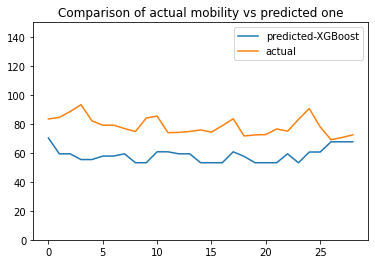

In [51]:
plt.plot(y_validation_pred_ln)
plt.plot(y_validation_true_ln)
plt.legend(['predicted-XGBoost',"actual"])
plt.ylim(0,150)
plt.title("Comparison of actual mobility vs predicted one")
plt.show()

**Use Auto AI to build the model and deploy it**

To use Auto AI, the user must use have an account on IBM cloud.

**Validation of Auto AI model to estimate london's transit mobility**

In [42]:
ln_y_validation_true = ln_validation_df['mobility'].values

In [43]:
array_of_input_fields = ['lockdown','air_temperature','lockdown_is_weekend','is_weekend']
values = ln_validation_df[['lockdown','air_temperature','lockdown_is_weekend','is_weekend']].values.tolist()

In [44]:
mltoken = os.environ['USER_ACCESS_TOKEN']

In [45]:
# NOTE: you must construct mltoken based on provided documentation	
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": [array_of_input_fields], "values": values}]}

ln_response_scoring = requests.post('https://zen-cpd-zen.emergent-alliance-cp4d-8adf5438ca4a45887fba35bbc75e0113-0000.eu-gb.containers.appdomain.cloud/v4/deployments/5037f573-8f65-4d70-afe8-3d2bf64b2822/predictions',
                                 json=payload_scoring, headers=header, verify=False)


In [47]:
ln_auto_ai_predictions = [x[0] for x in ln_response_scoring.json()['predictions'][0]['values']]
ln_auto_ai_pred = pd.DataFrame(ln_auto_ai_predictions,columns=['predictions'])

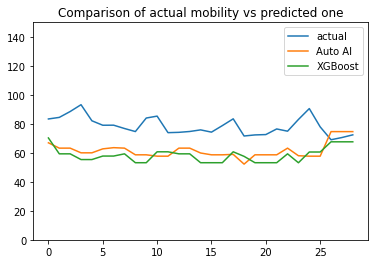

In [53]:
plt.plot(ln_y_validation_true)
plt.plot(ln_auto_ai_pred.values)
plt.plot(y_validation_pred_ln)
plt.legend(["actual","Auto AI","XGBoost"])
plt.ylim(0,150)
plt.title("Comparison of actual mobility vs predicted one")
plt.show()

In [49]:
mean_absolute_error(ln_y_validation_true,ln_auto_ai_pred.values)

**Observation**

The Auto AI models perform better than the custom XGBoost models. So the Auto AI models are used to estimate the transit mobility of Berlin and London.

The mobility prediction model is used to build a what-if analysis tool where the user can select a desired stringency value to visualise the estimated transit mobility for the next 9 days. The air temperature variable required for the prediction model is obtained from Yr, a weather forecast tool.

**Author**

* Shri Nishanth Rajendran - AI Development Specialist, R² Data Labs, Rolls Royce


Special thanks to Deepak Srinivasan and Alvaro Corrales Cano 